## Name: Margaret Nguyen

# Exploring the Impact of Infrastructure on Incident Rates for Vulnerable Road Users: A Machine Learning Analysis

**Assignment: Use the 'POPULATION' variable to conduct PCA and OLS models. This coding file is intended for the dataset without BNA score.**

In [129]:
# Import packages
import numpy as np # v 1.21.5
import sklearn # v 1.0.2
import pandas as pd # v 1.4.4
import ydata_profiling as pp # v 3.6.6
import statsmodels.api as sm # v 0.13.2

# Regression
from sklearn.linear_model import LinearRegression # v 1.0.2
from sklearn.model_selection import train_test_split # v 1.0.2

# PCA
from sklearn.decomposition import PCA # v 1.0.2
from sklearn.preprocessing import StandardScaler # v 1.0.2

from sklearn.metrics import mean_absolute_error # v 1.0.2
from sklearn.metrics import mean_squared_error # v 1.0.2
from sklearn.metrics import mean_absolute_percentage_error # v 1.0.2

# Ploting libraries 
import matplotlib
#matplotlib.use('Qt5Agg')  # Use an appropriate backend like 'Qt5Agg' for GUI display
import matplotlib.pyplot as plt # v 3.5.2
import seaborn as sns # v 0.11.2
# Display any generated plots or visualizations directly in the notebook interface
%matplotlib inline 

# I. Data Manipulation

In [130]:
# Read the csv file 
df_pa_acs = pd.read_csv('/Users/margaret06/Documents/GitHub/Carlisle_Borough_Transportation_Study/data/2017_TO_2021_MUNI_CRASH_DATA.csv')

df_mass_acs = pd.read_csv('/Users/margaret06/Documents/GitHub/Carlisle_Borough_Transportation_Study/data/df_mass_acs.csv', low_memory=False)

df_col_acs = pd.read_csv('/Users/margaret06/Documents/GitHub/Carlisle_Borough_Transportation_Study/data/df_col_acs.csv')

## A. Clean the Pennsylvania Crash Dataset

In [131]:
# Clean datasets
df_pa_acs.drop(columns = ['Unnamed: 0'], inplace=True)

# Select columns with numeric data types (int or float) using select_dtypes
numeric_columns = df_pa_acs.select_dtypes(include=['number'])

# Create a new DataFrame with only the numeric columns
df_pa_crash = df_pa_acs[numeric_columns.columns]

# Drop unnessary columns
df_pa_crash = df_pa_crash.drop(['PENN_DOT_MUNI_ID', 'state', 'county', 'county_subdivision', 'LAND_AREA.1', 'LAND_AREA', 'PENN_DOT_COUNTY_NUM', 'FEDERAL_EIN_CODE', 'HOME_RULE_YEAR', 'INCORPORATION_YEAR', 'MUNICIPALITY'], axis=1)

# Replace NaN values with 0 throughout the DataFrame to address missing data, following the experience of cleaning the original dataset.
df_pa_crash = df_pa_crash.fillna(0)

# Drop population == 0 (small municipalities)
df_pa_crash = df_pa_crash[df_pa_crash['POPULATION'] != 0]

# Reset index
df_pa_crash.reset_index(inplace = True, drop = True)

In [132]:
# Define the columns for which you want to calculate per capita values
columns_to_convert = [
    'BIKE_TO_WORK_EST', 'BIKE_TO_WORK_MARG',
    'WALK_TO_WORK_EST', 'WALK_TO_WORK_MARG', 'DRIVE_SOLO_TO_WORK_EST',
    'DRIVE_SOLO_TO_WORK_MARG', 'CARPOOL_TO_WORK_EST',
    'CARPOOL_TO_WORK_MARG', 'PUBTRANS_TO_WORK_EST',
    'PUBTRANS_TO_WORK_MARG', 'EMPLOYEES_FULL_TIME',
    'EMPLOYEES_PART_TIME', 'AUTOMOBILE_COUNT',
    'BICYCLE_BY_AUTO_COUNT', 'BICYCLE_DEATH_BY_AUTO_COUNT',
    'BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT', 'PED_BY_AUTO_COUNT',
    'PED_DEATH_BY_AUTO_COUNT', 'PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT',
    'BICYCLE_SOLO_COUNT', 'BICYCLE_DEATH_SOLO_COUNT',
    'BICYCLE_SUSP_SERIOUS_INJ_SOLO_COUNT', 'PED_SOLO_COUNT',
    'PED_DEATH_SOLO_COUNT', 'PED_SUSP_SERIOUS_INJ_SOLO_COUNT',
]

# Create new columns with "_PER_CAPITA" suffix by dividing each column by 'POPULATION'
for column in columns_to_convert:
    new_column_name = column + '_PER_CAPITA'
    df_pa_crash[new_column_name] = df_pa_crash[column] / df_pa_crash['POPULATION']

## B. Clean the Massachusett Crash Dataset

In [133]:
# Clean datasets
df_mass_acs.drop(columns = ['Unnamed: 0'], inplace=True)

# Exclude the NaN from 'VEHC_CONFIG_CL'
df_mass_crash = df_mass_acs[df_mass_acs['VEHC_CONFIG_CL'].notna()]

# List of NOT automobiles: Snowmobile, Moped, Motorcycle, Other Light Trucks (10,000 lbs., or Less), Other e.g. Farm Equipment, Unknown.
# Exclude the non-automobiles from 'VEHC_CONFIG_CL' columns
list_non_automobiles = ['V1:(Unknown vehicle configuration)', 'V1:(Other e.g. farm equipment)', 'V1:(Unknown vehicle configuration) / V2:(Unknown vehicle configuration)']
df_mass_crash= df_mass_crash[~df_mass_crash['VEHC_CONFIG_CL'].isin(list_non_automobiles)]

In [134]:
# Fatal - injuries that resulted in death 
# Incapacitating - serious injuries require immediate medical attention

## BICYCLE_DEATH_BY_AUTO_COUNT
# Filter the DataFrame for cyclist fatalities
cyclist_fatalities = df_mass_crash[(df_mass_crash['INJY_STAT_DESCR'] == 'Fatal injury (K)') & (df_mass_crash['NON_MTRST_TYPE_CL'] == 'Cyclist')]

# Group the filtered DataFrame by 'CITY_TOWN_NAME' and calculate the count for each city
bicycle_death_counts = cyclist_fatalities.groupby('CITY_TOWN_NAME').size().reset_index(name='BICYCLE_DEATH_BY_AUTO_COUNT')

# Merge the bicycle_death_counts DataFrame into df_mass_crash on 'CITY_TOWN_NAME'
df_mass_crash = df_mass_crash.merge(bicycle_death_counts, on='CITY_TOWN_NAME', how='left')

## BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT
cyclist_incapacitating = df_mass_crash[(df_mass_crash['INJY_STAT_DESCR'] == 'Non-fatal injury - Incapacitating') & (df_mass_crash['NON_MTRST_TYPE_CL'] == 'Cyclist')]
bicycle_sus_serious_inj_counts = cyclist_incapacitating.groupby('CITY_TOWN_NAME').size().reset_index(name='BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT')

# Merge the bicycle_sus_serious_inj_counts DataFrame into df_mass_crash on 'CITY_TOWN_NAME'
df_mass_crash = df_mass_crash.merge(bicycle_sus_serious_inj_counts, on='CITY_TOWN_NAME', how='left')

# Replace NaN values with 0 in the specified columns
df_mass_crash['BICYCLE_DEATH_BY_AUTO_COUNT'].fillna(0, inplace=True)
df_mass_crash['BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT'].fillna(0, inplace=True)

## BICYCLE_BY_AUTO_COUNT
df_mass_crash['BICYCLE_BY_AUTO_COUNT'] = df_mass_crash['BICYCLE_DEATH_BY_AUTO_COUNT'] + df_mass_crash['BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT']

## AUTOMOBILE_COUNT
auto_count = df_mass_crash.groupby('CITY_TOWN_NAME')['NUMB_VEHC'].sum().reset_index()
auto_count.rename(columns={'NUMB_VEHC': 'AUTOMOBILE_COUNT'}, inplace=True)
# Merge the auto_count into df_mass_crash on 'CITY_TOWN_NAME'
df_mass_crash = df_mass_crash.merge(auto_count, on='CITY_TOWN_NAME', how='left')

## PED_DEATH_BY_AUTO_COUNT
# Filter the DataFrame for pedestrian fatalities
ped_fatalities = df_mass_crash[(df_mass_crash['INJY_STAT_DESCR'] == 'Fatal injury (K)') & (df_mass_crash['NON_MTRST_TYPE_CL'] == 'Pedestrian')]

# Group the filtered DataFrame by 'CITY_TOWN_NAME' and calculate the count for each city
ped_death_counts = cyclist_fatalities.groupby('CITY_TOWN_NAME').size().reset_index(name='PED_DEATH_BY_AUTO_COUNT')

# Merge the ped_death_counts DataFrame into df_mass_crash on 'CITY_TOWN_NAME'
df_mass_crash = df_mass_crash.merge(ped_death_counts, on='CITY_TOWN_NAME', how='left')

## PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT
ped_incapacitating = df_mass_crash[(df_mass_crash['INJY_STAT_DESCR'] == 'Non-fatal injury - Incapacitating') & (df_mass_crash['NON_MTRST_TYPE_CL'] == 'Pedestrian')]
ped_sus_serious_inj_counts = ped_incapacitating.groupby('CITY_TOWN_NAME').size().reset_index(name='PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT')

# Merge the ped_sus_serious_inj_counts DataFrame into df_mass_crash on 'CITY_TOWN_NAME'
df_mass_crash = df_mass_crash.merge(ped_sus_serious_inj_counts, on='CITY_TOWN_NAME', how='left')

# Replace NaN values with 0 in the specified columns
df_mass_crash['PED_DEATH_BY_AUTO_COUNT'].fillna(0, inplace=True)
df_mass_crash['PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT'].fillna(0, inplace=True)

##PED_BY_AUTO_COUNT
df_mass_crash['PED_BY_AUTO_COUNT'] = df_mass_crash['PED_DEATH_BY_AUTO_COUNT'] + df_mass_crash['PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT']

# Drop the duplicated rows
df_mass_crash = df_mass_crash.drop_duplicates(subset=['CITY_TOWN_NAME', 'POPULATION', 
                                                      'BIKE_TO_WORK_EST', 'BICYCLE_BY_AUTO_COUNT', 
                                                      'BICYCLE_DEATH_BY_AUTO_COUNT', 
                                                      'BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT', 
                                                      'AUTOMOBILE_COUNT', 'PED_BY_AUTO_COUNT', 
                                                      'PED_DEATH_BY_AUTO_COUNT', 'PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT'])

In [135]:
# Select columns with numeric data types (int or float) using select_dtypes
numeric_columns = df_mass_crash.select_dtypes(include=['number'])

# Create a new DataFrame with only the numeric columns
df_mass_crash = df_mass_crash[numeric_columns.columns]

# Reset index
df_mass_crash.reset_index(drop = True, inplace = True)

In [136]:
# Define the columns for which you want to calculate per capita values
columns_to_convert = [
    'BIKE_TO_WORK_EST', 'BIKE_TO_WORK_MARG',
    'WALK_TO_WORK_EST', 'WALK_TO_WORK_MARG', 'DRIVE_SOLO_TO_WORK_EST',
    'DRIVE_SOLO_TO_WORK_MARG', 'CARPOOL_TO_WORK_EST',
    'CARPOOL_TO_WORK_MARG', 'PUBTRANS_TO_WORK_EST',
    'PUBTRANS_TO_WORK_MARG', 'AUTOMOBILE_COUNT',
    'BICYCLE_BY_AUTO_COUNT', 'BICYCLE_DEATH_BY_AUTO_COUNT',
    'BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT', 'PED_BY_AUTO_COUNT',
    'PED_DEATH_BY_AUTO_COUNT', 'PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT']

# Create new columns with "_PER_CAPITA" suffix by dividing each column by 'POPULATION'
for column in columns_to_convert:
    new_column_name = column + '_PER_CAPITA'
    df_mass_crash[new_column_name] = df_mass_crash[column] / df_mass_crash['POPULATION']

## C. Clean the Colorado Crash Dataset

In [137]:
# Clean datasets
df_col_acs.drop(columns = ['Unnamed: 0'], inplace=True)

In [138]:
# Nake a copy of df_col_acs
df_col_crash = df_col_acs.copy()

In [139]:
# Define the columns for which you want to calculate per capita values
columns_to_convert = [
    'BIKE_TO_WORK_EST', 'BIKE_TO_WORK_MARG',
    'WALK_TO_WORK_EST', 'WALK_TO_WORK_MARG', 'DRIVE_SOLO_TO_WORK_EST',
    'DRIVE_SOLO_TO_WORK_MARG', 'CARPOOL_TO_WORK_EST',
    'CARPOOL_TO_WORK_MARG', 'PUBTRANS_TO_WORK_EST',
    'PUBTRANS_TO_WORK_MARG', 
    'BICYCLE_BY_AUTO_COUNT', 'BICYCLE_DEATH_BY_AUTO_COUNT',
    'BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT', 'PED_BY_AUTO_COUNT',
    'PED_DEATH_BY_AUTO_COUNT', 'PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT']

# Create new columns with "_PER_CAPITA" suffix by dividing each column by 'POPULATION'
for column in columns_to_convert:
    new_column_name = column + '_PER_CAPITA'
    df_col_crash[new_column_name] = df_col_crash[column] / df_col_crash['POPULATION']

In [140]:
# Set the STATE coloumn
df_pa_crash['STATE'] = 'PA'
df_mass_crash['STATE'] = 'MA'
df_col_crash['STATE'] = 'CO'

In [141]:
# Find the common columns
common_columns = list(set(df_pa_crash.columns) & set(df_col_crash.columns) & set(df_mass_crash.columns))

# Keep to have the same columns
df_mass_crash = df_mass_crash[common_columns]
df_pa_crash = df_pa_crash[common_columns]
df_col_crash = df_col_crash[common_columns]

# Reorder the columns of the df_mass_crash and df_col_crash to match df_pa_crash
df_mass_crash = df_mass_crash[df_pa_crash.columns]
df_col_crash = df_col_crash[df_pa_crash.columns]

In [142]:
# Print the shape of each datadrame
df_mass_crash.shape, df_pa_crash.shape, df_col_crash.shape

((293, 34), (2565, 34), (127, 34))

## C. Merge df_pa_crash and df_mass_crash Dataframes

In [143]:
# Merge dataframes
crash_acs = pd.concat([df_pa_crash, df_mass_crash], axis=0)
df_crash_acs = pd.concat([crash_acs, df_col_crash], axis=0)

# Reset index
df_crash_acs.reset_index(drop = True, inplace = True)

# Check for the shape of the datafrane
print(df_crash_acs.shape)

# Show merge dataframe
df_crash_acs.head()

(2985, 34)


,PUBTRANS_TO_WORK_EST,WALK_TO_WORK_MARG_PER_CAPITA,BICYCLE_DEATH_BY_AUTO_COUNT_PER_CAPITA,PED_BY_AUTO_COUNT_PER_CAPITA,BIKE_TO_WORK_MARG,DRIVE_SOLO_TO_WORK_MARG_PER_CAPITA,DRIVE_SOLO_TO_WORK_EST,PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT_PER_CAPITA,BIKE_TO_WORK_MARG_PER_CAPITA,CARPOOL_TO_WORK_EST_PER_CAPITA,...,BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT_PER_CAPITA,PUBTRANS_TO_WORK_EST_PER_CAPITA,PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT,PUBTRANS_TO_WORK_MARG_PER_CAPITA,BIKE_TO_WORK_EST_PER_CAPITA,STATE,BIKE_TO_WORK_EST,BICYCLE_BY_AUTO_COUNT_PER_CAPITA,BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT,PED_DEATH_BY_AUTO_COUNT_PER_CAPITA
0,152058,0.001272,0.000005,0.001633,940,0.003261,343702,0.000134,0.000589,0.034744,...,0.000019,0.095223,214.0,0.002617,0.008875,PA,14172,0.000364,31.0,0.000051
1,23357,0.003407,0.000003,0.001778,290,0.006774,80593,0.000247,0.000956,0.033611,...,0.000013,0.077033,75.0,0.004129,0.006332,PA,1920,0.000274,4.0,0.000020
2,1813,0.009962,0.000000,0.001165,297,0.019826,6711,0.000074,0.007360,0.011994,...,0.000050,0.044930,3.0,0.009715,0.018066,PA,729,0.000347,2.0,0.000000
3,1482,0.004103,0.000010,0.001047,191,0.012058,28933,0.000105,0.001999,0.057319,...,0.000052,0.015512,10.0,0.003266,0.003444,PA,329,0.000481,5.0,0.000031
4,591,0.007382,0.000000,0.000208,116,0.035350,6363,0.000000,0.006030,0.060771,...,0.000104,0.030724,0.0,0.010969,0.013464,PA,259,0.000260,2.0,0.000000


**Create dumnmy variable for each dataframe**

In [144]:
df_crash_acs = pd.get_dummies(df_crash_acs, columns=['STATE'])

In [145]:
# Check for NaN missing values
df_crash_acs.isna().sum()

PUBTRANS_TO_WORK_EST                                 0
WALK_TO_WORK_MARG_PER_CAPITA                         0
BICYCLE_DEATH_BY_AUTO_COUNT_PER_CAPITA               0
PED_BY_AUTO_COUNT_PER_CAPITA                         0
BIKE_TO_WORK_MARG                                    0
DRIVE_SOLO_TO_WORK_MARG_PER_CAPITA                   0
DRIVE_SOLO_TO_WORK_EST                               0
PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT_PER_CAPITA        0
BIKE_TO_WORK_MARG_PER_CAPITA                         0
CARPOOL_TO_WORK_EST_PER_CAPITA                       0
PED_BY_AUTO_COUNT                                    0
CARPOOL_TO_WORK_MARG_PER_CAPITA                      0
POPULATION                                           0
WALK_TO_WORK_EST                                     0
BICYCLE_DEATH_BY_AUTO_COUNT                          0
PED_DEATH_BY_AUTO_COUNT                              0
DRIVE_SOLO_TO_WORK_MARG                              0
PUBTRANS_TO_WORK_MARG                                0
CARPOOL_TO

**Use Pandas Profiling**

In [146]:
#pp.ProfileReport(df_crash_acs)

# II. Principal Component Analysis (PCA)

### Credit: 
**The following code presented here is built upon the work of my supervisor, Mitch Shiles. You can access the original code by following this link: [Mitch Shiles' GitHub](https://github.com/rmshiles/Textiles-Spectroscopy-and-Supervised-Learning/blob/master/spectral%20analysis%20Final%20version.ipynb). I have made some adjustments to streamline and improve the code, aligning it with our specific usage requirements. I obtained permission from my supervisor to review and utilize his code for this internship project.**

For PCA, use the following variables:

- Bike to Work Estimate per Capita
- Walk to Work Estimate per Capita
- Drive to Work Estimate per Capita
- Take Public Transportation to Work per Capita
- Carpool to Work per Capita
- (Note: Land area per Capita is available only in df_pa_bna, so I will exclude it from the PCA.)

In [147]:
# Copy df_crash_acs as df_crash_filtered
df_crash_filtered = df_crash_acs.copy()

# Drop the binary column while running the PCA
df_crash_filtered = df_crash_filtered[['BIKE_TO_WORK_EST_PER_CAPITA', 
                                       'WALK_TO_WORK_EST_PER_CAPITA',
                                       'DRIVE_SOLO_TO_WORK_EST_PER_CAPITA',
                                       'CARPOOL_TO_WORK_EST_PER_CAPITA',
                                       'PUBTRANS_TO_WORK_EST_PER_CAPITA']]

In [148]:
# Normalize the features
crash_scaler = StandardScaler()
crash_std = crash_scaler.fit_transform(df_crash_filtered)

In [149]:
# Create a function to display the explained Variance related to principle components
def Number_of_Principle_Components(X_standardized,n_components):
    #Dimensionality reduction 
    # conduct principle compenent analysis on the data and examine the explained variance of the components
    from sklearn.decomposition import PCA
    sklearn_pca = PCA(n_components=n_components)
    Y_sklearn = sklearn_pca.fit_transform(X_standardized)
    pca = sklearn_pca.fit_transform(crash_std)
    plt.plot(sklearn_pca.explained_variance_ratio_)
    plt.show()
    print(
        'The percentage of total variance in the dataset explained by each',
        'component from Sklearn PCA.\n',
        sklearn_pca.explained_variance_ratio_
    )

    explained_variance = []
    explained_variance = sklearn_pca.explained_variance_ratio_

    total_variace = 0
    total_variace = 0
    components = 0
    num_prints = 0
    print('\n')
    for v in explained_variance:
        total_variace+=v
        components +=1

        if total_variace>=0.5 and total_variace<0.7 and num_prints < 1 :
            print(" to retain {}% of total variance  {} components are required".format(round(100*total_variace,2),components))
            num_prints+=1

        if total_variace>=0.7 and total_variace<0.8 and num_prints < 2 :
            print(" to retain {}% of total variance {} components required".format(round(100*total_variace,2),components))
            num_prints+=1

        elif total_variace>=0.8 and total_variace<0.9 and num_prints < 3 :
            print(" to retain {}% of total variance {} components required".format(round(100*total_variace,2),components))
            num_prints+=1

        elif total_variace>=0.9 and num_prints < 4  :
            print(" to retain {}% of total variance {} components required".format(round(100*total_variace,2),components))
            num_prints+=1

        else:
            None

    print(sum(explained_variance))

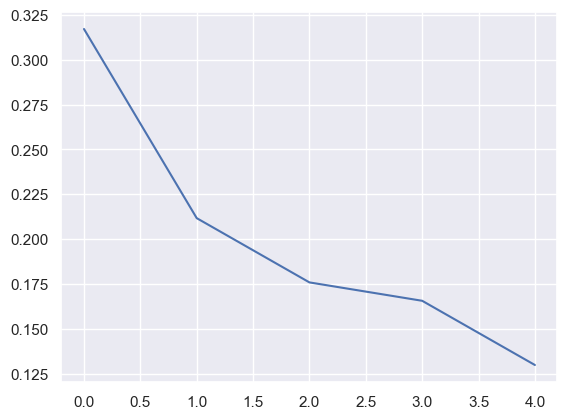

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.3171096  0.21166652 0.17583879 0.16559359 0.1297915 ]


 to retain 52.88% of total variance  2 components are required
 to retain 70.46% of total variance 3 components required
 to retain 87.02% of total variance 4 components required
 to retain 100.0% of total variance 5 components required
1.0


In [150]:
Number_of_Principle_Components(crash_std,5)

In [151]:
n_components = 4
pca = PCA(n_components)
crash_pca_components = pca.fit_transform(crash_std)
print(crash_pca_components[:4, :])

[[ 5.22035068 -1.88021487 -3.06771727 -1.27003108]
 [ 4.46617529 -1.70561077 -1.69846958 -1.05510968]
 [ 7.22279019 -2.11465976  1.56734507  0.96016519]
 [ 1.41302281  0.62288792 -0.28297637  0.0144891 ]]


In [152]:
df_crash_filtered[["PCA1", "PCA2", "PCA3", "PCA4"]] = crash_pca_components[:]
df_crash_filtered[["PCA1","PCA2","PCA3", "PCA4"]].head()

,PCA1,PCA2,PCA3,PCA4
0,5.220351,-1.880215,-3.067717,-1.270031
1,4.466175,-1.705611,-1.698470,-1.055110
2,7.222790,-2.114660,1.567345,0.960165
3,1.413023,0.622888,-0.282976,0.014489
4,2.859773,-0.119894,-1.476931,1.987929


Text(0.5, 1.0, 'Correlation Matrix')

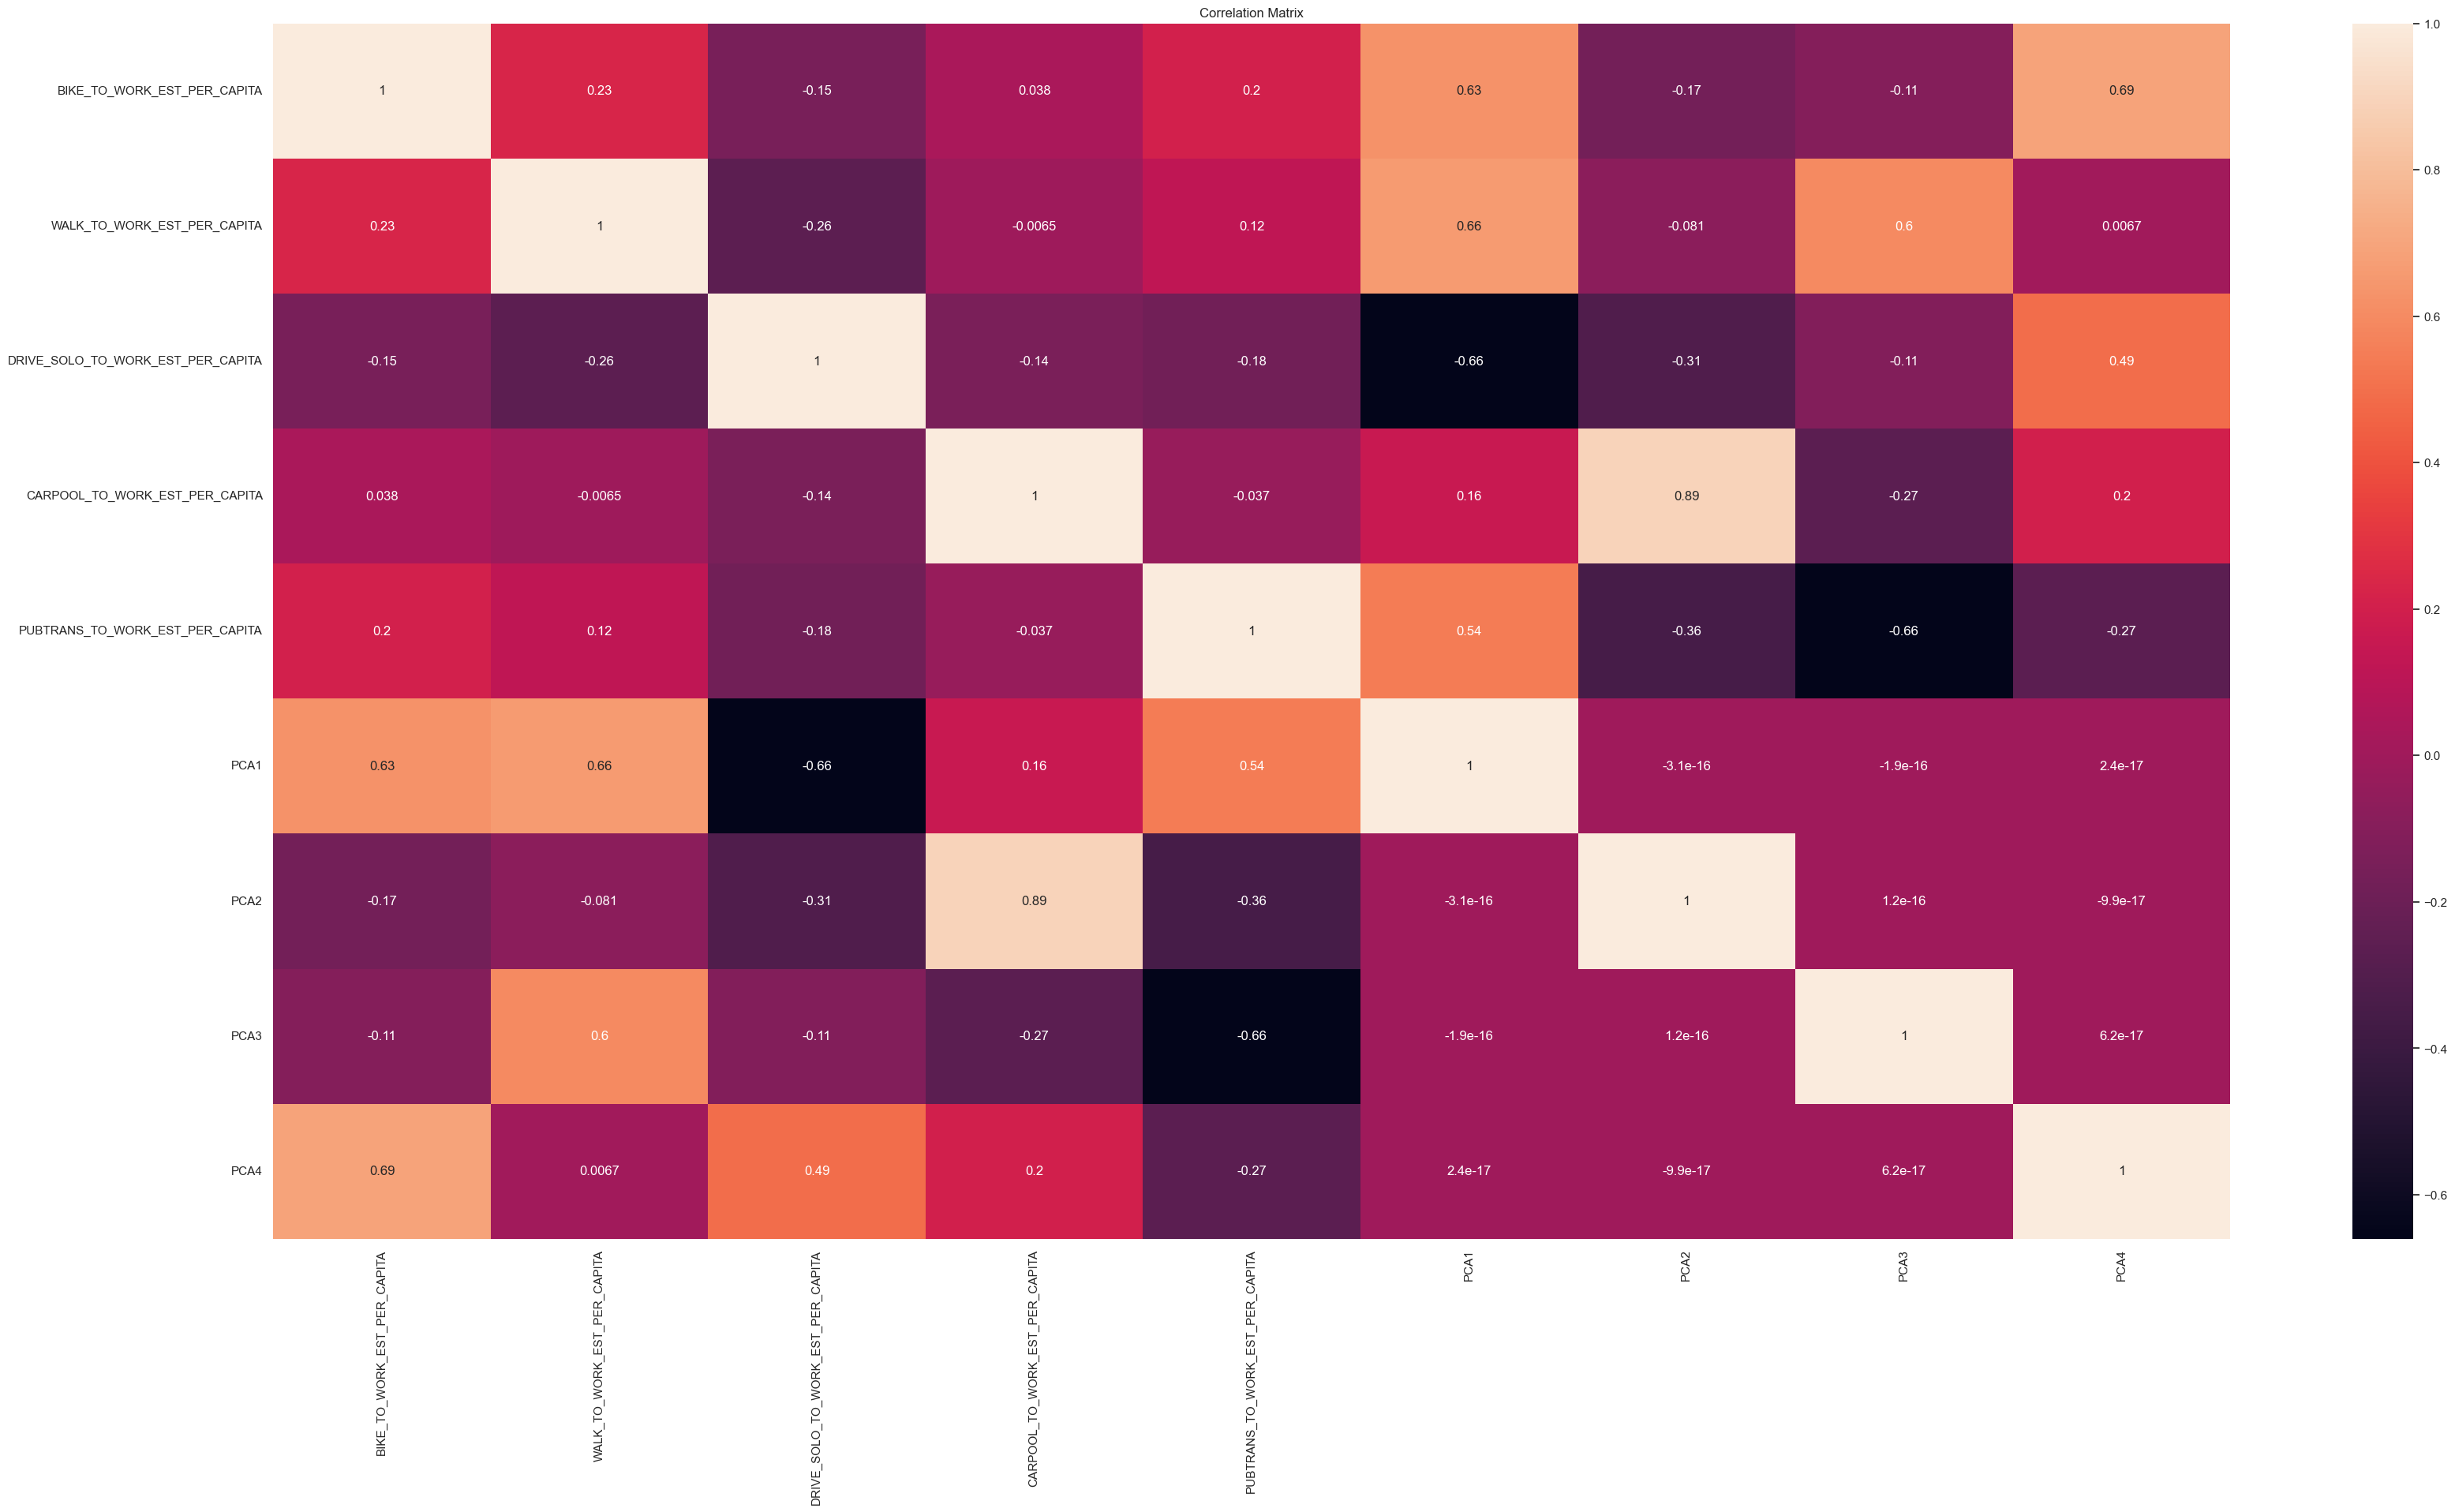

In [153]:
# Create heatmap
heat_corr = df_crash_filtered[['BIKE_TO_WORK_EST_PER_CAPITA', 'WALK_TO_WORK_EST_PER_CAPITA',
       'DRIVE_SOLO_TO_WORK_EST_PER_CAPITA', 'CARPOOL_TO_WORK_EST_PER_CAPITA',
       'PUBTRANS_TO_WORK_EST_PER_CAPITA', 'PCA1', 'PCA2', 'PCA3', 'PCA4']].corr()

plt.figure(figsize=(40,20))
sns.set(rc={'figure.facecolor':'w'})
sns.heatmap(heat_corr, annot=True) 
plt.title("Correlation Matrix")

# Save the heatmap as a PNG file
# plt.savefig('correlation_heatmap.png', format='png')
# plt.show()

In [154]:
# Add PCA components into the dataframe
df_crash_acs[["PCA1", "PCA2", "PCA3", "PCA4"]] = crash_pca_components[:]

# III. Ordinary Least Squares (OLS)

For the regression, include:

- All principal components
- Dummy variables for each state 
- Run the regression both with and without the BNA scores.

## A. Separate Dataset in Y (independent) and X (dependent) Variables

In [155]:
y = df_crash_acs["BICYCLE_BY_AUTO_COUNT_PER_CAPITA"] # Y = df_crash.BICYCLE_BY_AUTO_COUNT_PER_CAPITA
X = df_crash_acs[['STATE_CO', 'STATE_MA', 'STATE_PA', 'PCA1', 'PCA2', 'PCA3', 'PCA4']]

In [156]:
y2 = df_crash_acs["PED_BY_AUTO_COUNT_PER_CAPITA"] # Y = df_crash.PED_BY_AUTO_COUNT_PER_CAPITA
X2 = df_crash_acs[['STATE_CO', 'STATE_MA', 'STATE_PA', 'PCA1', 'PCA2', 'PCA3', 'PCA4']]

## B. Use the train_test_split Function to Split Data into Training (80%) and Testing Set (20%)

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [158]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=5)

## C. Fit, Run or Estimate the Regression Model

### 1. BICYCLE_BY_AUTO_COUNT_PER_CAPITA as the Dependent Variable

In [159]:
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

                                   OLS Regression Results                                   
Dep. Variable:     BICYCLE_BY_AUTO_COUNT_PER_CAPITA   R-squared:                       0.012
Model:                                          OLS   Adj. R-squared:                  0.009
Method:                               Least Squares   F-statistic:                     4.796
Date:                              Wed, 29 Nov 2023   Prob (F-statistic):           7.16e-05
Time:                                      12:55:22   Log-Likelihood:                 17223.
No. Observations:                              2388   AIC:                        -3.443e+04
Df Residuals:                                  2381   BIC:                        -3.439e+04
Df Model:                                         6                                         
Covariance Type:                          nonrobust                                         
                 coef    std err          t      P>|t|      [0.025    

In [160]:
# Make predictions on the test data
X_test = sm.add_constant(X_test) # Add a constant term to the test data
y_pred = model.predict(X_test)

### 2. PED_BY_AUTO_COUNT_PER_CAPITA as the Dependent Variable

In [161]:
X_train2 = sm.add_constant(X_train2)
model2 = sm.OLS(y_train2, X_train2).fit()
print(model2.summary())

                                 OLS Regression Results                                 
Dep. Variable:     PED_BY_AUTO_COUNT_PER_CAPITA   R-squared:                       0.048
Model:                                      OLS   Adj. R-squared:                  0.046
Method:                           Least Squares   F-statistic:                     20.13
Date:                          Wed, 29 Nov 2023   Prob (F-statistic):           4.50e-23
Time:                                  12:55:22   Log-Likelihood:                 15253.
No. Observations:                          2388   AIC:                        -3.049e+04
Df Residuals:                              2381   BIC:                        -3.045e+04
Df Model:                                     6                                         
Covariance Type:                      nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [162]:
# Make predictions on the test data
X_test2 = sm.add_constant(X_test2)  # Add a constant term to the test data
y_pred2 = model.predict(X_test2)

## D. Plot the Residuals

### Graph 1: The residuals for the model with 'BICYCLE_BY_AUTO_COUNT_PER_CAPITA' as the dependent variable

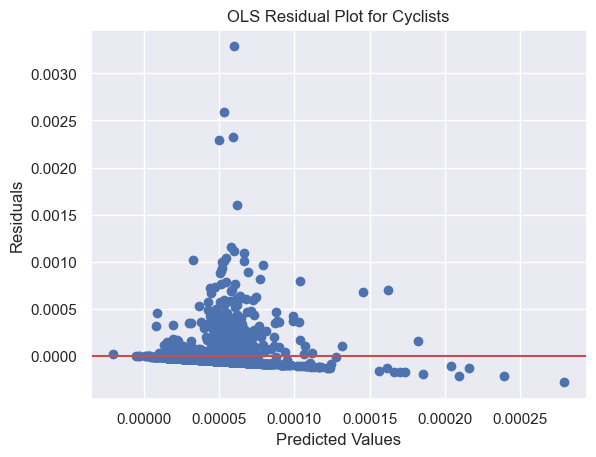

In [163]:
residuals = model.resid

plt.scatter(model.fittedvalues, residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("OLS Residual Plot for Cyclists")
plt.axhline(y=0, color='r', linestyle='-')  # Add a horizontal line at y=0
plt.show()

### Graph 2: The residuals for the model with 'PED_BY_AUTO_COUNT_PER_CAPITA' as the dependent variable

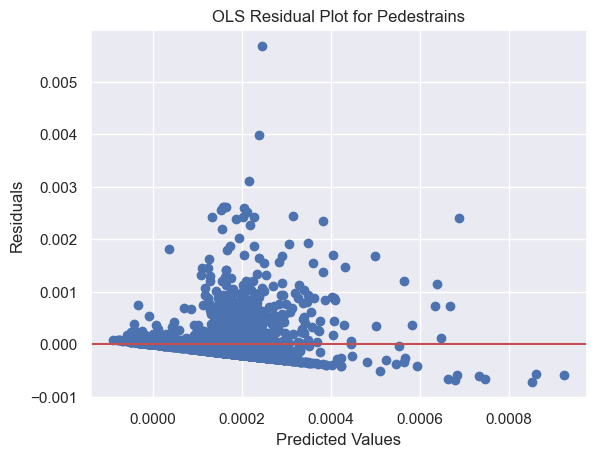

In [164]:
residuals2 = model2.resid

plt.scatter(model2.fittedvalues, residuals2)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("OLS Residual Plot for Pedestrains")
plt.axhline(y=0, color='r', linestyle='-')  # Add a horizontal line at y=0
plt.show()

## E. Plot the Actual vs. Predicted Values

### Graph 3: The Actual vs. Predicted Values for the model with 'BICYCLE_BY_AUTO_COUNT_PER_CAPITA' as the dependent variable

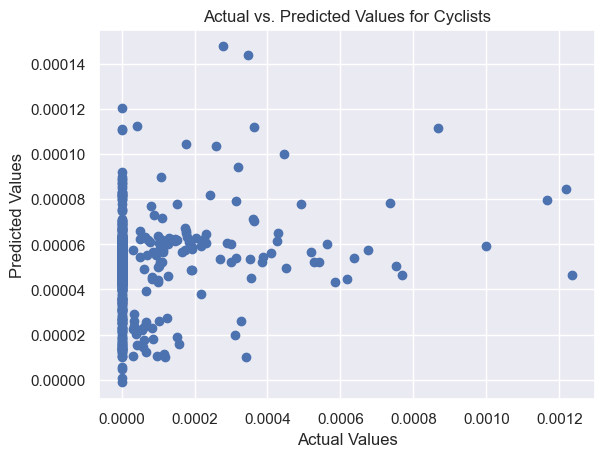

In [165]:
# Plot the actual vs. predicted values
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values for Cyclists")
plt.show()

### Graph 4: The Actual vs. Predicted Values for the model with 'PED_BY_AUTO_COUNT_PER_CAPITA' as the dependent variable

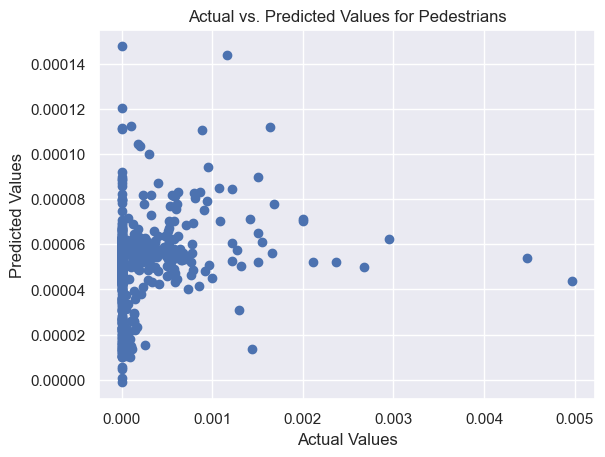

In [166]:
# Plot the actual vs. predicted values
plt.scatter(y_test2, y_pred2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values for Pedestrians")
plt.show()